<a href="https://colab.research.google.com/github/KirpaDmitriy/RetrievalAlgs/blob/main/decision_treeC45_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Лабораторная работа №2: Деревья решений</h1>
<h2>Дисциплина: Системы искусственного интеллекта</h2>

In [1]:
from math import log
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00623/DATA.csv

--2022-09-26 04:30:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/00623/DATA.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11024 (11K) [application/x-httpd-php]
Saving to: ‘DATA.csv’

DATA.csv            100%[===================>]  10.77K  --.-KB/s    in 0s      

2022-09-26 04:30:43 (126 MB/s) - ‘DATA.csv’ saved [11024/11024]



In [43]:
data_raw = pd.read_csv('DATA.csv', sep=';', index_col='STUDENT ID')
data_raw.head()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,COURSE ID,GRADE
STUDENT ID,,,,,,,,,,,,,,,,,,,,,
STUDENT1,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,1,2,1,1,1,1
STUDENT2,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,3,2,2,3,1,1
STUDENT3,2,2,2,3,2,2,2,2,4,2,...,1,1,2,2,1,1,2,2,1,1
STUDENT4,1,1,1,3,1,2,1,2,1,2,...,1,2,3,2,2,1,3,2,1,1
STUDENT5,2,2,1,3,2,2,1,3,1,4,...,2,1,2,2,2,1,2,2,1,1


In [54]:
data_raw.GRADE.unique()

array([1, 2, 5, 0, 3, 4, 7, 6])

In [66]:
N_FEATURES = int(data_raw.shape[1] ** 0.5)
data = data_raw.sample(N_FEATURES, axis=1)
data['GRADE'] = (data_raw.GRADE >= 3).astype(int)
data.head()

,23,14,8,16,19,GRADE
STUDENT ID,,,,,,
STUDENT1,1,1,1,5,2,0
STUDENT2,1,1,1,1,2,0
STUDENT3,1,1,2,1,2,0
STUDENT4,1,1,2,1,2,0
STUDENT5,2,1,3,4,1,0


In [67]:
data.groupby('GRADE').count()

,23,14,8,16,19
GRADE,,,,,
0,67,67,67,67,67
1,78,78,78,78,78


Классы примерно равны по размеру.

In [57]:
data.shape

(145, 6)

In [58]:
train, test = train_test_split(data, test_size=0.2)
train.shape, test.shape

((116, 6), (29, 6))

In [59]:
def freq(sample, cl):
  return (sample.GRADE == cl).sum()

def info(sample):
  summ = 0
  class_values = sample.GRADE.unique()
  for class_value in class_values:
    frequency = freq(sample, class_value) / sample.shape[0]
    summ += frequency * log(frequency, 2)
  return (-1) * summ

def infox(sample, split_field):
  summ = 0
  n = sample.shape[0]
  field_values = sample[split_field].unique()
  for field_value in field_values:
    same_field_value_subsample = sample[sample[split_field] == field_value]
    summ += same_field_value_subsample.shape[0] * info(same_field_value_subsample) / n
  return summ

def splitinfox(sample, split_field):
  summ = 0
  n = sample.shape[0]
  field_values = sample[split_field].unique()
  for field_value in field_values:
    same_field_value_subsample = sample[sample[split_field] == field_value]
    frequency = same_field_value_subsample.shape[0] / n
    summ += frequency * log(frequency, 2)
  return (-1) * summ

def gain_ratio(sample, split_field):
  return (info(sample) - infox(sample, split_field)) / splitinfox(sample, split_field)

In [60]:
class BerezaC45:
  counter = 0

  def __init__(self, sample):
    self.id = BerezaC45.counter
    BerezaC45.counter += 1
    sample_fields = sample.drop(columns='GRADE').columns
    sample_fields_gains = pd.Series(
        [
            gain_ratio(sample, sample_field) * int(len(sample[sample_field].unique()) != 1)
            for sample_field in sample_fields
        ]
    ).fillna(0)
    self.subtrees = {}
    self.most_frequent_target = sample.GRADE.mode()[0]
    self.split_field = None
    self.leaf_class = sample.GRADE.unique()
    if not any(sample_fields_gains) or len(sample.GRADE.unique()) == 1:
      self.leaf = True
      return
    self.split_field = sample_fields[np.argmax(sample_fields_gains)]
    self.leaf = False
    for split_field_value in sample[self.split_field].unique():
      self.subtrees[split_field_value] = BerezaC45(sample[sample[self.split_field] == split_field_value].drop(columns=self.split_field))
  
  def eval_one(self, sample_item):
    if not self.leaf:
      sep_val = sample_item[self.split_field]
      if sep_val in self.subtrees:
        return self.subtrees[sep_val].eval_one(sample_item)
      return self.most_frequent_target
    final_class = self.leaf_class
    assert len(final_class) != 0, 'Can not define class'
    if len(final_class) == 1:
      return final_class[0]
    return self.most_frequent_target
  
  def __str__(self):
    return f'Id: {self.id}. Included classes: {self.leaf_class}. Split field: {self.split_field}. Subtrees: {self.subtrees}'

In [61]:
berezka = BerezaC45(train)
print(berezka)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


Id: 0. Included classes: [1 0]. Split field: COURSE ID. Subtrees: {1: <__main__.BerezaC45 object at 0x7f5752a67590>, 3: <__main__.BerezaC45 object at 0x7f5753271f50>, 7: <__main__.BerezaC45 object at 0x7f57538ee9d0>, 5: <__main__.BerezaC45 object at 0x7f5753915510>, 2: <__main__.BerezaC45 object at 0x7f5752c46dd0>, 4: <__main__.BerezaC45 object at 0x7f57532c7f90>, 8: <__main__.BerezaC45 object at 0x7f5754ffed10>, 9: <__main__.BerezaC45 object at 0x7f5753915450>, 6: <__main__.BerezaC45 object at 0x7f57533549d0>}


In [71]:
test_results = []
marked_as_positive_indexes = set()
positive_indexes = set()
marked_as_negative_indexes = set()
negative_indexes = set()

for i in range(test.shape[0]):
  model_estimation = berezka.eval_one(test.drop(columns='GRADE').iloc[i])
  if test.iloc[i].GRADE:
    positive_indexes.add(i)
  else:
    negative_indexes.add(i)
  test_results.append(model_estimation)
  if model_estimation:
    marked_as_positive_indexes.add(i)
  else:
    marked_as_negative_indexes.add(i)
print(f'Акуратность: {(np.array(test_results) == np.array(test.GRADE.tolist())).astype(int).sum() / len(test_results)}')

Акуратность: 0.6896551724137931


In [77]:
true_positive = marked_as_positive_indexes & positive_indexes
print(f'Точность для класса студентов с высокими оценками: {len(true_positive) / len(marked_as_positive_indexes)}')
print(f'Полнота для класса студентов с высокими оценками: {len(true_positive) / len(positive_indexes)}')

Точность для класса студентов с высокими оценками: 0.6666666666666666
Полнота для класса студентов с высокими оценками: 0.8


In [78]:
true_negative = marked_as_negative_indexes & negative_indexes
print(f'Точность для класса студентов с низкими оценнками: {len(true_negative) / len(marked_as_negative_indexes)}')
print(f'Полнота для класса студентов с низкими оценками: {len(true_negative) / len(negative_indexes)}')

Точность для класса студентов с низкими оценнками: 0.7272727272727273
Полнота для класса студентов с низкими оценками: 0.5714285714285714


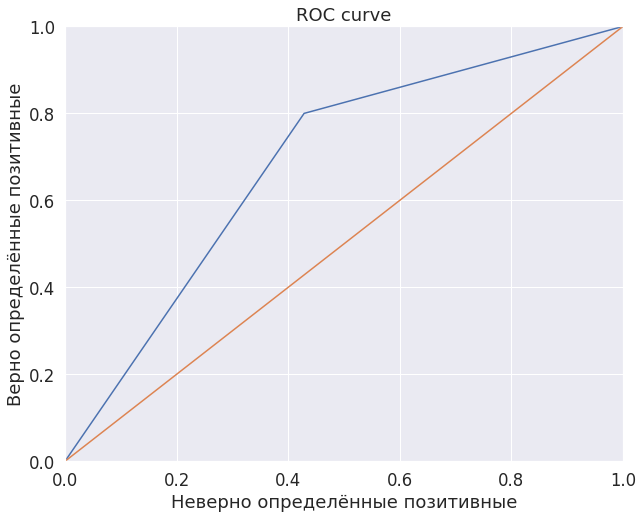

In [90]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(test.GRADE.tolist(), test_results)
plt.plot(fpr, tpr, label='ROC кривая ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Неверно определённые позитивные')
plt.ylabel('Верно определённые позитивные')
plt.title('ROC curve')
plt.show()

In [94]:
import plotly.express as px
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(test.GRADE.tolist(), test_results)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall кривая',
    labels=dict(x='Полнота', y='Точность'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

<h2>Выводы</h2>
В ходе лабораторной работы я реализовал дерево решений, понял принципы его работы, нашёл и испраил множество багов, оценил качество модели. Используя простейшую модель, не подбирая никаких парметров на довольно сложном в плане нахождения универсальных закономерностей датасете получил относительно высокую точность.

<i><u>Источники</u></i>:
<ul>
  <li><a href="https://ru.wikipedia.org/wiki/ID3_(алгоритм)">Алгоритм ID3</a></li>
  <li><a href="https://archive.ics.uci.edu">Данные</a></li>
  <li><a href="https://habr.com/ru/company/ods/blog/328372/">Построение ROC-кривой</a></li>
  <li><a href="https://plotly.com/python/roc-and-pr-curves/">Построение PR-кривой</a></li>
</ul>